# Imports

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


In [2]:
from collections import Counter
import torchvision
from PIL import Image

# Connect

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Config

In [4]:
class config:
  SEED=42
  images_path = '/content/gdrive/MyDrive/licenta/dataset/poze'
  val_file_path = '/content/gdrive/MyDrive/licenta/dataset/validare.txt'
  test_file_path = '/content/gdrive/MyDrive/licenta/dataset/test.txt'
  save_path ='/content/gdrive/MyDrive/licenta/model_vgg16_scratch_improved_v1.pt'
  BATCH_SIZE = 1
  map_emotions = {0: "Surprise", 1: "Fear",2: "Disgust",3: "Happiness",4: "Sadness",5: "Anger",6: "Neutral"}
  num_classes = 7
  feature_extract=False
  DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
data_dir = config.images_path

# Model definition

In [6]:
class MyVGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(MyVGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.1), # modificat
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.1), # modificat
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out1 = self.fc1(out)
        out2 = self.fc2(out)
        return out1, out2

# Util Function



In [7]:
def initialize_model( num_classes):
    model = MyVGG16(num_classes).to(config.DEVICE)
    input_size = 224
    return model, input_size

model, input_size = initialize_model(config.num_classes)


In [8]:
model.load_state_dict(torch.load(config.save_path))

<All keys matched successfully>

In [9]:
import matplotlib.pyplot as plt

def plot_class_distribution(targets, dataset_name):
    counts = Counter(targets)
    classes = list(counts.keys())
    instances = list(counts.values())

    plt.figure(figsize=(10, 5))
    plt.bar(classes, instances)
    plt.xlabel('Class')
    plt.ylabel('Number of instances')
    plt.title(f'Class distribution in {dataset_name}')
    plt.show()

# Load Test data

In [10]:
data_transforms_test = {
    'test': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor()
    ])
}

print("Initializing Datasets...")

image_test_datasets = datasets.ImageFolder(root = os.path.join(data_dir,'test'),transform=data_transforms_test['test'])
image_val_datasets = datasets.ImageFolder(root = os.path.join(data_dir,'val'),transform=data_transforms_test['test'])

Initializing Datasets...


In [11]:
len(image_test_datasets),len(image_val_datasets)

(3068, 1707)

In [12]:
# get unique file paths and labels
file_paths_labels_test = list(set(image_test_datasets.imgs))
file_paths_labels_val = list(set(image_val_datasets.imgs))

# # update ImageFolder dataset with unique samples
# image_test_datasets.imgs = file_paths_labels_test
# image_test_datasets.samples = file_paths_labels

In [13]:
file_paths_labels_val

[('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06648.jpg', 0),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06943.jpg', 0),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06212.jpg', 0),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06558.jpg', 0),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/6/train_07310.jpg', 5),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06929.jpg', 0),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/5/train_06903.jpg', 4),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/5/train_07006.jpg', 4),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/7/train_11950.jpg', 6),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/5/train_07471.jpg', 4),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/4/train_07326.jpg', 3),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/4/train_07128.jpg', 3),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/4/train_06707.jpg', 3),
 ('/content/

In [14]:
image_val_datasets.samples

[('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06189.jpg', 0),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06203.jpg', 0),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06209.jpg', 0),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06212.jpg', 0),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06228.jpg', 0),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06236.jpg', 0),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06242.jpg', 0),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06243.jpg', 0),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06244.jpg', 0),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06259.jpg', 0),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06261.jpg', 0),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06275.jpg', 0),
 ('/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06281.jpg', 0),
 ('/content/

In [15]:
from torch.utils.data import ConcatDataset

combined_dataset = ConcatDataset([image_val_datasets, image_test_datasets])
combined_targets =image_val_datasets.targets+ image_test_datasets.targets
combined_image_paths = [sample[0] for sample in image_val_datasets.samples+image_test_datasets.samples]


In [16]:
len(combined_dataset)

4775

In [17]:
len(combined_image_paths), combined_image_paths[4000], combined_image_paths[10]

(4775,
 '/content/gdrive/MyDrive/licenta/dataset/poze/test/6/test_1309.jpg',
 '/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06261.jpg')

# Split data into query-value using balanced test set

In [18]:
from torch.utils.data import Subset
from sklearn.utils import resample

# Calculate the number of instances for each class
counts = Counter(combined_targets)

# Find the class with the minimum number of instances
min_class = min(counts.keys(), key=(lambda k: counts[k]))
min_count = counts[min_class]

# Collect indices for each class
indices_by_class = {k: [] for k in counts.keys()}
for idx, label in enumerate(combined_targets):
    indices_by_class[label].append(idx)

# Undersample each class to match the smallest class
undersampled_indices = []
for k, v in indices_by_class.items():
    undersampled_indices.extend(resample(v, replace=False, n_samples=min_count, random_state=config.SEED))

# Create a new dataset with balanced classes
balanced_dataset = Subset(combined_dataset, undersampled_indices)

Balanced dataset: Counter({0: 97, 1: 97, 2: 97, 3: 97, 4: 97, 5: 97, 6: 97})


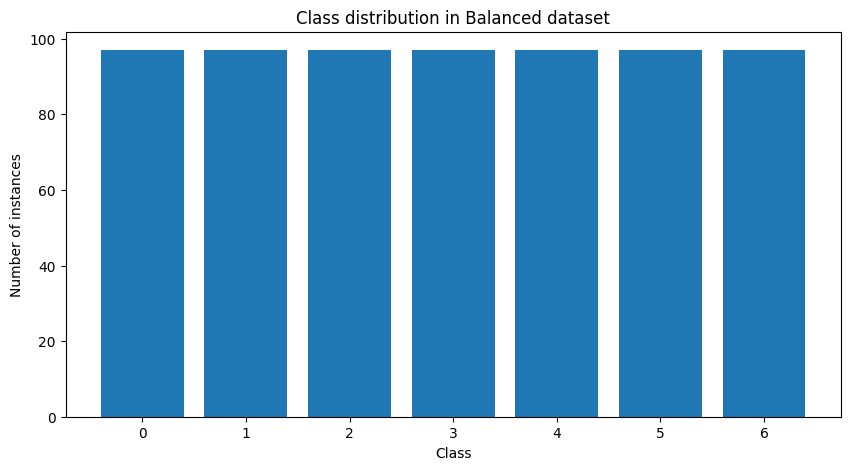

In [19]:
balanced_targets = [combined_targets[i] for i in undersampled_indices]

balanced_counts = Counter(balanced_targets)
print("Balanced dataset:", balanced_counts)
plot_class_distribution(balanced_targets, 'Balanced dataset')

In [20]:
num_samples = len(balanced_targets)
num_samples

679

In [21]:
len(balanced_targets)

679

In [22]:
list(set(balanced_targets))

[0, 1, 2, 3, 4, 5, 6]

Create query - reference datasets

In [23]:
from sklearn.model_selection import train_test_split

class_labels = list(set(balanced_targets))

indices_per_class = {label: np.where(np.array(balanced_targets) == label)[0] for label in class_labels}

# Split indices for each class with a ratio of 75%/25%
ref_idx = []
query_idx = []
for label, indices in indices_per_class.items():
    ref, query = train_test_split(indices, test_size=0.25, random_state=config.SEED)
    ref_idx.extend(ref)
    query_idx.extend(query)

ref_dataset = torch.utils.data.Subset(balanced_dataset, ref_idx)
query_dataset = torch.utils.data.Subset(balanced_dataset, query_idx)

In [24]:
print('Number of selected instances as references:',len(ref_idx))
print('Number of selected instances as query:',len(query_idx))

Number of selected instances as references: 504
Number of selected instances as query: 175


Query dataset: Counter({0: 25, 1: 25, 2: 25, 3: 25, 4: 25, 5: 25, 6: 25})
Reference dataset: Counter({0: 72, 1: 72, 2: 72, 3: 72, 4: 72, 5: 72, 6: 72})


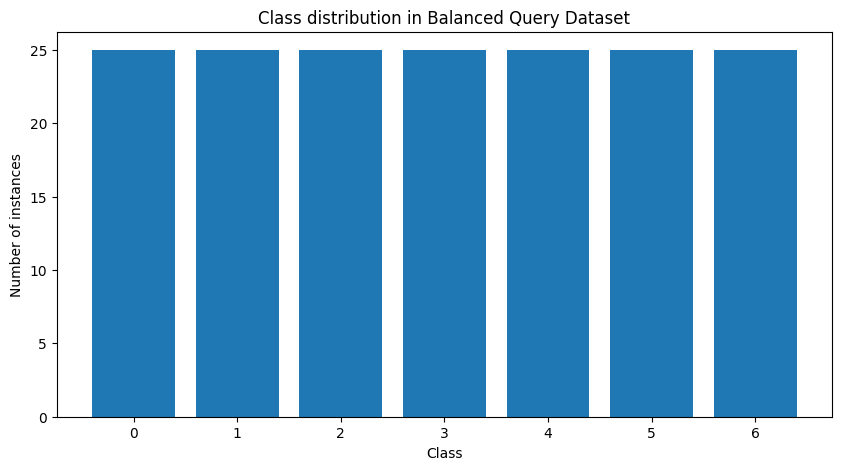

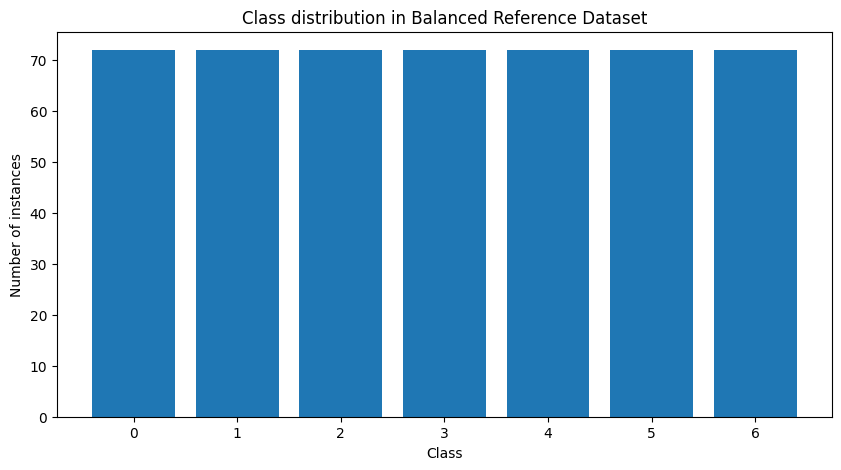

In [25]:
ref_targets = [balanced_targets[i] for i in ref_idx]
query_targets = [balanced_targets[i] for i in query_idx]

ref_counts = Counter(ref_targets)
query_counts = Counter(query_targets)

print("Query dataset:", query_counts)
print("Reference dataset:", ref_counts)

plot_class_distribution(query_targets, 'Balanced Query Dataset')
plot_class_distribution(ref_targets, 'Balanced Reference Dataset')


In [26]:
def common_data(list1, list2):
    result = False
    for x in list1:
        for y in list2:
            if x == y:
                result = True
                print(x)
    return result

# Feed data into the model to get descriptors

In [27]:
model=model.to(config.DEVICE)

In [28]:
from torch.autograd import Variable

In [29]:
len(combined_image_paths), combined_image_paths[4000]

(4775, '/content/gdrive/MyDrive/licenta/dataset/poze/test/6/test_1309.jpg')

In [30]:
# import torch
# import torchvision
# import torchvision.transforms as T
# from PIL import Image

def get_dictionaries_of_descriptors(target_dataset):
  model.eval()
  # transform = T.ToPILImage()
  descriptors = {}
  for i, (input, target) in enumerate(target_dataset):
    input = Variable(input).unsqueeze(0)
    if torch.cuda.is_available():
        input = input.cuda()

    with torch.set_grad_enabled(False):
        output = model(input)
        descriptor = output[0]
        _, pred = torch.max(output[1], 1)
        img = combined_image_paths[balanced_dataset.indices[target_dataset.indices[i]]]
        descriptors[img] = {"descriptor": descriptor.detach(), "class": pred.item(),"true_label":target}
    # if i==10:
    #   img = combined_image_paths[balanced_dataset.indices[target_dataset.indices[i]]]
    #   print(img)
    #   img_q = transform(input[0])
    #   img_q.show()
    #   break
  return descriptors

In [31]:
query_dict = get_dictionaries_of_descriptors(query_dataset)
query_dict

{'/content/gdrive/MyDrive/licenta/dataset/poze/test/1/test_1985.jpg': {'descriptor': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.6437, 0.0000, 0.0000]],
         device='cuda:0'),
  'class': 3,
  'true_label': 0},
 '/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_07585.jpg': {'descriptor': tensor([[0.0714, 0.0000, 0.0000,  ..., 0.3485, 0.0852, 0.0000]],
         device='cuda:0'),
  'class': 4,
  'true_label': 0},
 '/content/gdrive/MyDrive/licenta/dataset/poze/test/1/test_0035.jpg': {'descriptor': tensor([[0.4198, 0.0000, 0.4136,  ..., 0.1817, 0.3323, 0.0000]],
         device='cuda:0'),
  'class': 4,
  'true_label': 0},
 '/content/gdrive/MyDrive/licenta/dataset/poze/test/1/test_1556.jpg': {'descriptor': tensor([[0.1946, 0.0000, 0.0000,  ..., 0.4209, 0.2323, 0.0000]],
         device='cuda:0'),
  'class': 4,
  'true_label': 0},
 '/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06275.jpg': {'descriptor': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.6249, 0.0000, 0.0000]],
    

In [32]:
for i, (k, v) in enumerate(query_dict.items()):
  print(i, v['true_label'])

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1
50 2
51 2
52 2
53 2
54 2
55 2
56 2
57 2
58 2
59 2
60 2
61 2
62 2
63 2
64 2
65 2
66 2
67 2
68 2
69 2
70 2
71 2
72 2
73 2
74 2
75 3
76 3
77 3
78 3
79 3
80 3
81 3
82 3
83 3
84 3
85 3
86 3
87 3
88 3
89 3
90 3
91 3
92 3
93 3
94 3
95 3
96 3
97 3
98 3
99 3
100 4
101 4
102 4
103 4
104 4
105 4
106 4
107 4
108 4
109 4
110 4
111 4
112 4
113 4
114 4
115 4
116 4
117 4
118 4
119 4
120 4
121 4
122 4
123 4
124 4
125 5
126 5
127 5
128 5
129 5
130 5
131 5
132 5
133 5
134 5
135 5
136 5
137 5
138 5
139 5
140 5
141 5
142 5
143 5
144 5
145 5
146 5
147 5
148 5
149 5
150 6
151 6
152 6
153 6
154 6
155 6
156 6
157 6
158 6
159 6
160 6
161 6
162 6
163 6
164 6
165 6
166 6
167 6
168 6
169 6
170 6
171 6
172 6
173 6
174 6


In [33]:
ref_dict = get_dictionaries_of_descriptors(ref_dataset)
ref_dict

{'/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_07588.jpg': {'descriptor': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.5240, 0.0000, 0.0000]],
         device='cuda:0'),
  'class': 4,
  'true_label': 0},
 '/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_07013.jpg': {'descriptor': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.6759, 0.0000, 0.0000]],
         device='cuda:0'),
  'class': 4,
  'true_label': 0},
 '/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_07420.jpg': {'descriptor': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.6193, 0.0000, 0.0000]],
         device='cuda:0'),
  'class': 3,
  'true_label': 0},
 '/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06646.jpg': {'descriptor': tensor([[0.0677, 0.0000, 0.0000,  ..., 0.4123, 0.0456, 0.0000]],
         device='cuda:0'),
  'class': 4,
  'true_label': 0},
 '/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_07115.jpg': {'descriptor': tensor([[0.0000, 0.0000, 0.3398,  ..., 0.4932, 0.0000, 0.0000]],
 

In [34]:
common_data(ref_dict.keys(),query_dict.keys())

False

# Save Images

In [ ]:
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
import re

def save_images(target_dict, dir_path):
  for k,v in target_dict.items():
    img = read_image(k)
    img = T.ToPILImage()(img)
    name = re.split(r"/[0-9]/", k )[1]
    img_class = v['true_label']+1
    new_path = dir_path +f'{img_class}/{name}'
    img.save(new_path)

In [ ]:
query_dir_path = '/content/gdrive/MyDrive/licenta/dataset/poze/query/'
ref_dir_path = '/content/gdrive/MyDrive/licenta/dataset/poze/reference/'

In [ ]:
save_images(query_dict,query_dir_path)

In [ ]:
save_images(ref_dict,ref_dir_path)

# Create the matrix of distances

In [35]:
# Extract the descriptors and labels from the dictionaries
ref_descriptors_tensors = torch.stack([value["descriptor"] for value in ref_dict.values()])
ref_labels = [value["class"] for value in ref_dict.values()]

query_descriptors_tensors = torch.stack([value["descriptor"] for value in query_dict.values()])
query_labels = [value["class"] for value in query_dict.values()]

In [36]:
new_ref_tensors = ref_descriptors_tensors.squeeze(1)
new_query_tensors =query_descriptors_tensors.squeeze(1)

In [37]:
from sklearn.metrics.pairwise import euclidean_distances
euclidean_dist_matrix = euclidean_distances(new_query_tensors.cpu().numpy(),new_ref_tensors.cpu().numpy())

In [38]:
euclidean_dist_matrix.shape

(175, 504)

In [39]:
euclidean_dist_matrix

array([[14.822027 , 14.916455 , 14.660746 , ..., 27.56474  , 23.312582 ,
        30.600153 ],
       [ 9.4593725, 14.616352 , 12.290099 , ..., 15.279219 , 12.777006 ,
        19.955614 ],
       [17.99911  , 24.330355 , 22.651731 , ..., 11.117525 , 12.969651 ,
        17.12572  ],
       ...,
       [23.457752 , 31.09622  , 29.445724 , ..., 14.7262945, 14.332052 ,
         7.2938075],
       [19.011114 , 26.154263 , 24.088575 , ...,  5.7437167, 12.846113 ,
         8.521063 ],
       [17.211203 , 20.640938 , 19.960472 , ..., 12.347951 , 12.42174  ,
        17.884571 ]], dtype=float32)

In [40]:
print('Number of query descriptors:',len(query_descriptors_tensors))
print('Number of reference descriptors:',len(ref_descriptors_tensors))

Number of query descriptors: 175
Number of reference descriptors: 504


In [41]:
tensor_euclidean_matrix = torch.tensor(euclidean_dist_matrix)

In [42]:
sorted_dist_matrix, indices = torch.sort(tensor_euclidean_matrix, dim=1)

In [43]:
print(sorted_dist_matrix)
print('Shape of the matrix Nb_query_descriptors x Nb_ref_descriptors:',sorted_dist_matrix.shape,f'= {sorted_dist_matrix.shape[0]} x {sorted_dist_matrix.shape[1]}')

tensor([[ 8.7562,  9.0802,  9.0922,  ..., 42.6772, 42.7391, 47.9029],
        [ 5.0183,  5.0935,  5.2334,  ..., 42.7702, 44.1742, 45.7718],
        [ 5.2099,  5.8197,  6.2163,  ..., 45.2113, 45.8256, 46.2360],
        ...,
        [ 7.2938,  7.3630,  7.4331,  ..., 49.3797, 53.6725, 54.2167],
        [ 4.8818,  5.7407,  5.7437,  ..., 46.2985, 51.1408, 51.2186],
        [ 7.0238,  7.7784,  7.7883,  ..., 42.1605, 46.6605, 46.6780]])
Shape of the matrix Nb_query_descriptors x Nb_ref_descriptors: torch.Size([175, 504]) = 175 x 504


In [44]:
query_image_names = list(query_dict.keys())
ref_image_names = list(ref_dict.keys())

In [45]:
query_image_names

['/content/gdrive/MyDrive/licenta/dataset/poze/test/1/test_1985.jpg',
 '/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_07585.jpg',
 '/content/gdrive/MyDrive/licenta/dataset/poze/test/1/test_0035.jpg',
 '/content/gdrive/MyDrive/licenta/dataset/poze/test/1/test_1556.jpg',
 '/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06275.jpg',
 '/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06729.jpg',
 '/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06663.jpg',
 '/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_07177.jpg',
 '/content/gdrive/MyDrive/licenta/dataset/poze/test/1/test_1869.jpg',
 '/content/gdrive/MyDrive/licenta/dataset/poze/test/1/test_1732.jpg',
 '/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_07460.jpg',
 '/content/gdrive/MyDrive/licenta/dataset/poze/test/1/test_1530.jpg',
 '/content/gdrive/MyDrive/licenta/dataset/poze/test/1/test_1458.jpg',
 '/content/gdrive/MyDrive/licenta/dataset/poze/val/1/train_06559.jpg',
 '/content/gd

In [46]:
# For each image in the query set
for i, query_image_name in enumerate(query_image_names):
    print("Query image:", query_image_name)
    img_q = Image.open(query_image_name).resize((224, 224))
    img_q.show()

    # Get the indices of the K most similar images in the query set
    closest_indices = indices[i, :5].tolist()

    # Print the most similar images
    for idx in closest_indices:
        print(f"Similar image nb {idx}:", ref_image_names[idx])
        img_r = Image.open(ref_image_names[idx]).resize((224, 224))
        img_r.show()


Output hidden; open in https://colab.research.google.com to view.

# Measure precision-recall

In [47]:
query_images_by_class = {0:[],1:[],2:[],3:[],4:[],5:[],6:[]}

for idx, (k,v) in enumerate(query_dict.items()):
  imgs = query_images_by_class[v['true_label']]
  imgs.append(idx)
  query_images_by_class[v['true_label']] = imgs

In [48]:
def countmatching(iterable, *predicates):
    v = [0] * len(predicates)
    for e in iterable:
        for i,p in enumerate(predicates):
            if p(e):
                v[i] += 1
    return tuple(v)[0]

In [49]:
def compute_means(k, query_image_names_idx, real_label, indices, ref_dict_list, n_samples_in_ref):
  avg_prec_per_class=0
  avg_rec_per_class=0

  # for each image from query images
  for img_idx in query_image_names_idx:
    # Get the indices of the K most similar images from reference set
    closest_indices = indices[img_idx, :k].tolist()
    ret_labels = []

    # from those k closest images from reference set, save their true labels
    for i in closest_indices:
      ret_labels.append(ref_dict_list[i]['true_label'])

    # count how many of their true label match the class
    n_correct_idx = countmatching(ret_labels, lambda a: a==real_label)

    avg_prec_per_class += n_correct_idx / k
    avg_rec_per_class += n_correct_idx / n_samples_in_ref


  return avg_prec_per_class / len(query_image_names_idx), avg_rec_per_class/len(query_image_names_idx)

In [50]:
len(ref_image_names)

504

In [51]:
k_interval = np.linspace(1,len(ref_image_names), 50).astype(int)
#k_interval = np.linspace(15,450, 50).astype(int)
k_interval

array([  1,  11,  21,  31,  42,  52,  62,  72,  83,  93, 103, 113, 124,
       134, 144, 154, 165, 175, 185, 196, 206, 216, 226, 237, 247, 257,
       267, 278, 288, 298, 308, 319, 329, 339, 350, 360, 370, 380, 391,
       401, 411, 421, 432, 442, 452, 462, 473, 483, 493, 504])

In [53]:
prec_per_k = []
rec_per_k = []
num_classes=7
for k in k_interval:
  current_prec = 0
  current_rec = 0
  for class_label in range(num_classes):
    #idx form query dataset that are from the current class for which we compute precision & recall
    query_idx_per_class= [i for i,val in enumerate(query_dict.values()) if val['true_label']==class_label]
    ref_dict_list= list(ref_dict.values())

    # nb of images that have as true label the current class_label
    n_samples_in_ref= countmatching(ref_dict_list, lambda a: a['true_label']==class_label)

    avg_prec_per_class, avg_rec_per_class=compute_means(k,query_idx_per_class, class_label, indices, ref_dict_list, n_samples_in_ref)
    current_prec += avg_prec_per_class
    current_rec += avg_rec_per_class

  prec_per_k.append(current_prec/num_classes)
  rec_per_k.append(current_rec/num_classes)


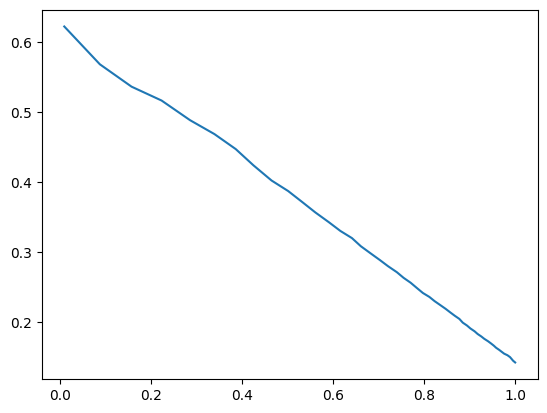

In [54]:
import matplotlib.pyplot as plt

plt.plot(rec_per_k,prec_per_k )

## Compute precision & recall for one k

In [55]:
current_prec = 0
current_rec = 0
k=504
for class_label in range(7):
  query_idx_per_class= [i for i,val in enumerate(query_dict.values()) if val['true_label']==class_label]
  ref_dict_list= list(ref_dict.values())
  # print(len(ref_dict_list))
  n_samples_in_ref= countmatching(ref_dict_list, lambda a: a['true_label']==class_label)
  avg_prec_per_class, avg_rec_per_class=compute_means(k,query_idx_per_class, class_label, indices, ref_dict_list, n_samples_in_ref)
  current_prec += avg_prec_per_class
  current_rec += avg_rec_per_class
print('prec:',current_prec/7)
print('rec:',current_rec/7)


prec: 0.14285714285714282
rec: 1.0
